# Final Model for C3 Euclidian Resorting

In [30]:
model_name = 'EEGNetTunerC3Euc'

## Initialize

### Pip install amd import functions

In [31]:
import pickle
import numpy as np

# mne imports
import mne
from mne import io
from mne.datasets import sample

# EEGNet-specific imports
from tensorflow.keras import utils as np_utils
from tensorflow.keras.callbacks import ModelCheckpoint

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Activation, Permute, Dropout
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import SeparableConv2D, DepthwiseConv2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import SpatialDropout2D
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.layers import Input, Flatten
from tensorflow.keras.constraints import max_norm
from tensorflow.keras import backend as K

from keras.utils import custom_object_scope


# PyRiemann imports
from pyriemann.estimation import XdawnCovariances
from pyriemann.tangentspace import TangentSpace
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression

# tools for plotting confusion matrices
from matplotlib import pyplot as plt

In [32]:
def EEGNet(nb_classes, Chans = 64, Samples = 128, 
             dropoutRate = 0.5, kernLength = 64, F1 = 8, 
             D = 2, F2 = 16, norm_rate = 0.25, dropoutType = 'Dropout'):
    """ Keras Implementation of EEGNet
    http://iopscience.iop.org/article/10.1088/1741-2552/aace8c/meta

    Note that this implements the newest version of EEGNet and NOT the earlier
    version (version v1 and v2 on arxiv). We strongly recommend using this
    architecture as it performs much better and has nicer properties than
    our earlier version. For example:
        
        1. Depthwise Convolutions to learn spatial filters within a 
        temporal convolution. The use of the depth_multiplier option maps 
        exactly to the number of spatial filters learned within a temporal
        filter. This matches the setup of algorithms like FBCSP which learn 
        spatial filters within each filter in a filter-bank. This also limits 
        the number of free parameters to fit when compared to a fully-connected
        convolution. 
        
        2. Separable Convolutions to learn how to optimally combine spatial
        filters across temporal bands. Separable Convolutions are Depthwise
        Convolutions followed by (1x1) Pointwise Convolutions. 
        
    
    While the original paper used Dropout, we found that SpatialDropout2D 
    sometimes produced slightly better results for classification of ERP 
    signals. However, SpatialDropout2D significantly reduced performance 
    on the Oscillatory dataset (SMR, BCI-IV Dataset 2A). We recommend using
    the default Dropout in most cases.
        
    Assumes the input signal is sampled at 128Hz. If you want to use this model
    for any other sampling rate you will need to modify the lengths of temporal
    kernels and average pooling size in blocks 1 and 2 as needed (double the 
    kernel lengths for double the sampling rate, etc). Note that we haven't 
    tested the model performance with this rule so this may not work well. 
    
    The model with default parameters gives the EEGNet-8,2 model as discussed
    in the paper. This model should do pretty well in general, although it is
	advised to do some model searching to get optimal performance on your
	particular dataset.

    We set F2 = F1 * D (number of input filters = number of output filters) for
    the SeparableConv2D layer. We haven't extensively tested other values of this
    parameter (say, F2 < F1 * D for compressed learning, and F2 > F1 * D for
    overcomplete). We believe the main parameters to focus on are F1 and D. 

    Inputs:
        
      nb_classes      : int, number of classes to classify
      Chans, Samples  : number of channels and time points in the EEG data
      dropoutRate     : dropout fraction
      kernLength      : length of temporal convolution in first layer. We found
                        that setting this to be half the sampling rate worked
                        well in practice. For the SMR dataset in particular
                        since the data was high-passed at 4Hz we used a kernel
                        length of 32.     
      F1, F2          : number of temporal filters (F1) and number of pointwise
                        filters (F2) to learn. Default: F1 = 8, F2 = F1 * D. 
      D               : number of spatial filters to learn within each temporal
                        convolution. Default: D = 2
      dropoutType     : Either SpatialDropout2D or Dropout, passed as a string.

    """
    
    if dropoutType == 'SpatialDropout2D':
        dropoutType = SpatialDropout2D
    elif dropoutType == 'Dropout':
        dropoutType = Dropout
    else:
        raise ValueError('dropoutType must be one of SpatialDropout2D '
                         'or Dropout, passed as a string.')
    
    input1   = Input(shape = (Chans, Samples, 1))

    ##################################################################
    block1       = Conv2D(F1, (1, kernLength), padding = 'same',
                                   input_shape = (Chans, Samples, 1),
                                   use_bias = False)(input1)
    block1       = BatchNormalization()(block1)
    block1       = DepthwiseConv2D((Chans, 1), use_bias = False, 
                                   depth_multiplier = D,
                                   depthwise_constraint = max_norm(1.))(block1)
    block1       = BatchNormalization()(block1)
    block1       = Activation('elu')(block1)
    block1       = AveragePooling2D((1, 4))(block1)
    block1       = dropoutType(dropoutRate)(block1)
    
    block2       = SeparableConv2D(F2, (1, 16),
                                   use_bias = False, padding = 'same')(block1)
    block2       = BatchNormalization()(block2)
    block2       = Activation('elu')(block2)
    block2       = AveragePooling2D((1, 8))(block2)
    block2       = dropoutType(dropoutRate)(block2)
        
    flatten      = Flatten(name = 'flatten')(block2)
    
    dense        = Dense(nb_classes, name = 'dense', 
                         kernel_constraint = max_norm(norm_rate))(flatten)
    softmax      = Activation('softmax', name = 'softmax')(dense)
    
    return Model(inputs=input1, outputs=softmax)


In [33]:
K.set_image_data_format('channels_last')

### Load data

In [34]:
import scipy.io

classes = scipy.io.loadmat("/mnt/d/sharegit/MasterThesis_data/TimeSeries/classes.mat")['classes']
ERPs = scipy.io.loadmat("/mnt/d/sharegit/MasterThesis_data/TimeSeries/ERPs.mat")['ERPs']


### Preprocess data

In [35]:
X = ERPs.copy()*1000 # format is in (trials, channels, samples)
y = classes.T[0].copy()
print(y)

[ 1  1  1 ... 12 12 12]


In [36]:
# Define your 2D grid dimensions
grid_x, grid_y = 5, 5  # Assuming a 5x5 grid based on the images provided

# Initialize a new array with an extra dimension for the 3D grid
X_3D = np.zeros((X.shape[0], grid_x, grid_y, X.shape[2]))

channel_indices = {
    0: 1,  # 'FP2'
    1: 11,  # 'F8'
    2: 19,  # 'AFz'
    3: 3,  # 'F4'
    4: 10,  # 'F7'
    5: 0,  # 'FP1'
    6: 16,  # 'FZ'
    7: 12,  # 'T7'
    8: 2,  # 'F3'
    9: 4,  # 'C3'
    10: 6,  # 'P3'
    11: 17,  # 'CZ'
    12: 14,  # 'P7'
    13: 8,  # 'O1'
    14: 20,  # 'CPZ'
    15: 18,  # 'PZ'
    16: 5,  # 'C4'
    17: 21,  # 'POZ'
    18: 7,  # 'P4'
    19: 13,  # 'T8'
    20: 9,  # 'O2'
    21: 15  # 'P8'
}

X_re = X.copy()
# Iterate over each trial and channel to populate the 3D grid
#for trial in range(X.shape[0]):
for ch_idx, ch_idx_reorder in channel_indices.items():
    # Assign the channel data to the correct location in the grid
    X_re[:,ch_idx,:]= X[:, ch_idx_reorder, :]

In [37]:

from sklearn.model_selection import train_test_split

# Assuming ERPs is your data with the shape (trials, channels, samples)
X = ERPs*1000 # format is in (trials, channels, samples)
y = classes.T[0].copy()

mod = [1,1,1,1,2,2,2,2,3,3,3,3]
for i, replacement in enumerate(mod, start=1):
    y[classes.T[0] == i] = replacement


# Split the data into 50% training and 50% temp (which will later be split into test and validation)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.5, random_state=42)

# Split the temp data into 50% test and 50% validation, resulting in 25% of the original data each
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
print(y_train)
num_classess = len(set(y_train))
print(f'There are {num_classess} unique classes in the dataset')

[1 2 2 ... 3 1 3]
There are 3 unique classes in the dataset


In [38]:
from collections import Counter

# the syntax is {class_1:weight_1, class_2:weight_2,...}. Here just setting
# the weights all to be 1
# Count the occurrences of each class
counts = Counter(y)

# Calculate the total number of samples
total_samples = sum(counts.values())

# Number of classes
num_classes = len(counts)

# Calculate class weights
class_weights = {class_label-1: total_samples / (num_classes * count) for class_label, count in counts.items()}
#class_weights = {0:1, 1:1, 2:1}
print(class_weights)

{0: 1.1282511210762332, 1: 0.9469326307866014, 2: 0.9455092070650132}


In [39]:
kernels, chans, samples = 1, 22, 1250


# convert labels to one-hot encodings.
y_train      = np_utils.to_categorical(y_train-1)
y_val   = np_utils.to_categorical(y_val-1)
y_test       = np_utils.to_categorical(y_test-1)
print(y_train)
# convert data to NHWC (trials, channels, samples, kernels) format. Data
X_train      = X_train.reshape(X_train.shape[0], chans, samples, kernels)
X_val   = X_val.reshape(X_val.shape[0], chans, samples, kernels)
X_test       = X_test.reshape(X_test.shape[0], chans, samples, kernels)

print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')


[[1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 ...
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]]
X_train shape: (3774, 22, 1250, 1)
3774 train samples
1887 test samples


## Implement EEGNET without Hyperparameters

### Compile model

In [11]:
model = EEGNet(nb_classes = num_classess, Chans = chans, Samples = samples,
               dropoutRate = 0.5, kernLength = 32, F1 = 8, D = 2, F2 = 16,
               dropoutType = 'Dropout')

# compile the model and set the optimizers
model.compile(loss='categorical_crossentropy', optimizer='adam',
              metrics = ['accuracy'])
# count number of parameters in the model
numParams    = model.count_params()

model.summary()

2024-06-06 19:14:38.231031: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 22, 1250, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 22, 1250, 8)       256       
                                                                 
 batch_normalization (Batch  (None, 22, 1250, 8)       32        
 Normalization)                                                  
                                                                 
 depthwise_conv2d (Depthwis  (None, 1, 1250, 16)       352       
 eConv2D)                                                        
                                                                 
 batch_normalization_1 (Bat  (None, 1, 1250, 16)       64        
 chNormalization)                                                
                                                             

2024-06-06 19:14:38.460661: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-06 19:14:38.460707: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-06 19:14:38.463641: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-06 19:14:38.463680: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-06 19:14:38.463702: I tensorflow/compile

### Train model

In [14]:
from tensorflow.keras.callbacks import ModelCheckpoint

# set a valid path for your system to record model checkpoints
checkpoint_path= '/mnt/d/sharegit/MasterThesis_data/' + model_name + '/checkpoint.h5'
checkpointer = ModelCheckpoint(filepath=checkpoint_path, verbose=1, save_best_only=True)

# load optimal weights
#model.load_weights('checkpoint_ACC65p_3class.keras', by_name=True, skip_mismatch=True)
fittedModel = model.fit(X_train, y_train, batch_size = 16, epochs = 1000,
                        verbose = 2, validation_data=(X_val, y_val),
                        callbacks=checkpointer, class_weight = class_weights)

Epoch 1/1000

Epoch 1: val_loss improved from inf to 1.07784, saving model to /mnt/d/sharegit/MasterThesis_data/EEGNetTunerC3Euc/checkpoint.h5
236/236 - 2s - loss: 1.0738 - accuracy: 0.4099 - val_loss: 1.0778 - val_accuracy: 0.4075 - 2s/epoch - 8ms/step
Epoch 2/1000


/home/lkcepza/anaconda3/envs/tf_test/lib/python3.11/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 2: val_loss improved from 1.07784 to 1.07524, saving model to /mnt/d/sharegit/MasterThesis_data/EEGNetTunerC3Euc/checkpoint.h5
236/236 - 2s - loss: 1.0699 - accuracy: 0.4184 - val_loss: 1.0752 - val_accuracy: 0.4261 - 2s/epoch - 9ms/step
Epoch 3/1000

Epoch 3: val_loss improved from 1.07524 to 1.07253, saving model to /mnt/d/sharegit/MasterThesis_data/EEGNetTunerC3Euc/checkpoint.h5
236/236 - 2s - loss: 1.0695 - accuracy: 0.4134 - val_loss: 1.0725 - val_accuracy: 0.4128 - 2s/epoch - 8ms/step
Epoch 4/1000

Epoch 4: val_loss improved from 1.07253 to 1.06280, saving model to /mnt/d/sharegit/MasterThesis_data/EEGNetTunerC3Euc/checkpoint.h5
236/236 - 2s - loss: 1.0591 - accuracy: 0.4221 - val_loss: 1.0628 - val_accuracy: 0.4293 - 2s/epoch - 8ms/step
Epoch 5/1000

Epoch 5: val_loss improved from 1.06280 to 1.06091, saving model to /mnt/d/sharegit/MasterThesis_data/EEGNetTunerC3Euc/checkpoint.h5
236/236 - 2s - loss: 1.0525 - accuracy: 0.4433 - val_loss: 1.0609 - val_accuracy: 0.4314 - 2

### Save parameters

In [16]:
filepath = '/mnt/d/sharegit/MasterThesis_data/' + model_name + '/modelFitted.pkl'

# Open the file in write-binary mode and dump the variables
with open(filepath, 'wb') as f:
    pickle.dump({'fittedModel': fittedModel, 'model': model}, f)

## EEGNET with Hyperparameters

### Define model and train using random search

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorboard.plugins.hparams import api as hp
import numpy as np
import scipy.io
import os
from PIL import Image
from keras_tuner.tuners import GridSearch, RandomSearch, Hyperband, BayesianOptimization

from keras.utils import get_custom_objects
from keras.optimizers import AdamW

2024-06-06 21:10:15.493345: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-06 21:10:15.797192: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-06 21:10:15.797227: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-06 21:10:15.799019: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-06 21:10:15.939097: I tensorflow/core/platform/cpu_feature_g

In [2]:
def build_model(hp):
    get_custom_objects().update({'AdamW': AdamW})
    nb_classes = 3
    kernels, Chans, Samples = 1, 22, 1250

    kernLength = hp.Int(f'kernLength', 32, 256, step = 32) # 32,
    F1 = hp.Int(f'F1', 6, 12, step = 2)
    D = hp.Int(f'D', 2, 8, step = 1)
    dropoutRate = hp.Float(f'dropoutRate', 0, 0.7, step = 0.2)
    F2 = hp.Int(f'F2', 16, 32, step = 4)
    norm_rate = 0.25
    opt = hp.Choice(f'optimizer', ['adam', 'AdamW'])
    dropoutType = hp.Choice('dropoutType',['Dropout', 'SpatialDropout2D'] )

    if dropoutType == 'SpatialDropout2D':
        dropoutType = SpatialDropout2D
    elif dropoutType == 'Dropout':
        dropoutType = Dropout
    else:
        raise ValueError('dropoutType must be one of SpatialDropout2D '
                         'or Dropout, passed as a string.')

    input1   = Input(shape = (Chans, Samples, 1))
    ##################################################################
    block1       = Conv2D(F1, (1, kernLength), padding = 'same',
                                   input_shape = (Chans, Samples, 1),
                                   use_bias = False)(input1)
    block1       = BatchNormalization()(block1)
    block1       = DepthwiseConv2D((Chans, 1), use_bias = False,
                                   depth_multiplier = D,
                                   depthwise_constraint = max_norm(1.))(block1)
    block1       = BatchNormalization()(block1)
    block1       = Activation('elu')(block1)
    block1       = AveragePooling2D((1, 4))(block1)
    block1       = dropoutType(dropoutRate)(block1)

    block2       = SeparableConv2D(F2, (1, 16),
                                   use_bias = False, padding = 'same')(block1)
    block2       = BatchNormalization()(block2)
    block2       = Activation('elu')(block2)
    block2       = AveragePooling2D((1, 8))(block2)
    block2       = dropoutType(dropoutRate)(block2)

    flatten      = Flatten(name = 'flatten')(block2)

    dense        = Dense(nb_classes, name = 'dense',
                         kernel_constraint = max_norm(norm_rate))(flatten)
    softmax      = Activation('softmax', name = 'softmax')(dense)

    model = Model(inputs=input1, outputs=softmax)

    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

    #model.load_weights('/content/drive/MyDrive/NNcodes/Checkpoints/checkpoint_ACC65p_3class_1000epocs.keras', by_name=True, skip_mismatch=True)

    return model

### Train RandomSearch

In [ ]:
tuner_rs = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=300,
    executions_per_trial=1,
    directory='/mnt/d/sharegit/MasterThesis_data/'+ model_name +'/logs/rs',
    project_name='EEGNetTunerC3Euc',
    overwrite=False
)

tuner_rs.search(X_train, y_train, epochs=20, validation_data=(X_val, y_val), class_weight = class_weights,
             callbacks=[keras.callbacks.TensorBoard('/mnt/d/sharegit/MasterThesis_data/'+ model_name +'/logs/rs/rs_logs')])

Trial 229 Complete [00h 00m 30s]
val_accuracy: 0.5622681379318237

Best val_accuracy So Far: 0.5903550386428833
Total elapsed time: 02h 14m 05s

Search: Running Trial #230

Value             |Best Value So Far |Hyperparameter
192               |32                |kernLength
10                |8                 |F1
4                 |8                 |D
0.2               |0                 |dropoutRate
24                |16                |F2
adam              |adam              |optimizer
Dropout           |Dropout           |dropoutType



### Visualize Results using Tensorboard

In [29]:
%reload_ext tensorboard

In [42]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [49]:
%tensorboard --logdir /mnt/d/sharegit/MasterThesis_data/EEGNetTunerC3Euc/logs/rs/rs_logs

## Train using hyperparameters

### Compile model

In [52]:
model = EEGNet(nb_classes = num_classess, Chans = chans, Samples = samples,
               dropoutRate = 0.2, kernLength = 32, F1 = 8, D = 8, F2 = 16,
               dropoutType = 'Dropout')

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# count number of parameters in the model
model.count_params()

model.summary()

2024-06-06 22:53:10.642600: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-06 22:53:10.688535: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-06 22:53:10.688582: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-06 22:53:10.692252: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-06 22:53:10.692296: I tensorflow/compile

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 22, 1250, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 22, 1250, 8)       256       
                                                                 
 batch_normalization (Batch  (None, 22, 1250, 8)       32        
 Normalization)                                                  
                                                                 
 depthwise_conv2d (Depthwis  (None, 1, 1250, 64)       1408      
 eConv2D)                                                        
                                                                 
 batch_normalization_1 (Bat  (None, 1, 1250, 64)       256       
 chNormalization)                                                
                                                             

r/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-06 22:53:10.815360: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-06 22:53:10.815465: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-06 22:53:10.815474: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1977] Could not identify NUMA node of platform GPU id 0, defaulting to 0.  Your kernel may not have been built with NUMA support.
2024-06-06 22:53:10.815548: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to r

### Train model

In [54]:
# set a valid path for your system to record model checkpoints
checkpointer = ModelCheckpoint(filepath='/mnt/d/sharegit/MasterThesis_data/' + model_name + '/checkpoint_hyperparam.h5', verbose=1,   save_best_only=True)

# load optimal weights
#model.load_weights('checkpoint_ACC65p_3class.keras', by_name=True, skip_mismatch=True)
fittedModel = model.fit(X_train, y_train, batch_size = 16, epochs = 1000,
                        verbose = 2, validation_data=(X_val, y_val),
                        callbacks=[checkpointer], class_weight = class_weights)

Epoch 1/1000

Epoch 1: val_loss improved from inf to 1.06576, saving model to /mnt/d/sharegit/MasterThesis_data/EEGNetTunerC3Euc/checkpoint_hyperparam.h5
236/236 - 2s - loss: 1.0570 - accuracy: 0.4377 - val_loss: 1.0658 - val_accuracy: 0.4499 - 2s/epoch - 8ms/step
Epoch 2/1000


/home/lkcepza/anaconda3/envs/tf_test/lib/python3.11/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 2: val_loss improved from 1.06576 to 1.04965, saving model to /mnt/d/sharegit/MasterThesis_data/EEGNetTunerC3Euc/checkpoint_hyperparam.h5
236/236 - 2s - loss: 1.0386 - accuracy: 0.4605 - val_loss: 1.0497 - val_accuracy: 0.4520 - 2s/epoch - 8ms/step
Epoch 3/1000

Epoch 3: val_loss improved from 1.04965 to 1.03719, saving model to /mnt/d/sharegit/MasterThesis_data/EEGNetTunerC3Euc/checkpoint_hyperparam.h5
236/236 - 2s - loss: 1.0255 - accuracy: 0.4740 - val_loss: 1.0372 - val_accuracy: 0.4536 - 2s/epoch - 7ms/step
Epoch 4/1000

Epoch 4: val_loss did not improve from 1.03719
236/236 - 2s - loss: 1.0066 - accuracy: 0.4989 - val_loss: 1.0396 - val_accuracy: 0.4573 - 2s/epoch - 7ms/step
Epoch 5/1000

Epoch 5: val_loss did not improve from 1.03719
236/236 - 2s - loss: 0.9954 - accuracy: 0.5117 - val_loss: 1.0420 - val_accuracy: 0.4637 - 2s/epoch - 7ms/step
Epoch 6/1000

Epoch 6: val_loss did not improve from 1.03719
236/236 - 2s - loss: 0.9818 - accuracy: 0.5098 - val_loss: 1.0471 - va

### Save model results

In [55]:
filepath = '/mnt/d/sharegit/MasterThesis_data/' + model_name + '/modelFittedHyperParam.pkl'

# Open the file in write-binary mode and dump the variables
with open(filepath, 'wb') as f:
    pickle.dump({'fittedModel': fittedModel, 'model': model}, f)


## Assessment

### Accuracy evaluation both methods

In [13]:
# Replace 'your_file.pkl' with the path to your pickle file
filepath = '/mnt/d/sharegit/MasterThesis_data/' + model_name + '/modelFitted.pkl'

with open(filepath, 'rb') as f:
    data = pickle.load(f)

fittedModel = data['fittedModel']
model = data['model']

# load optimal weights
model.load_weights('/mnt/d/sharegit/MasterThesis_data/' + model_name + '/checkpoint.h5')

probs       = model.predict(X_test)
preds       = probs.argmax(axis = -1)
acc         = np.mean(preds == y_test.argmax(axis=-1))
print("Classification accuracy: %f " % (acc))

2024-07-18 00:07:01.079032: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-18 00:07:01.336709: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-18 00:07:01.336758: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-18 00:07:01.341093: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-18 00:07:01.341135: I tensorflow/compile

40/59 [===================>..........] - ETA: 0s 

2024-07-18 00:07:03.531990: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


59/59 [==============================] - 1s 3ms/step
Classification accuracy: 0.679915 


In [15]:
# Replace 'your_file.pkl' with the path to your pickle file
filepath = '/mnt/d/sharegit/MasterThesis_data/' + model_name + '/modelFittedHyperParam.pkl'

with open(filepath, 'rb') as f:
    data = pickle.load(f)

fittedModel_hp = data['fittedModel']
model_hp = data['model']

# load optimal weights
model_hp.load_weights('/mnt/d/sharegit/MasterThesis_data/' + model_name + '/checkpoint_hyperparam.h5')

probs       = model_hp.predict(X_test)
preds_hp       = probs.argmax(axis = -1)
acc         = np.mean(preds == y_test.argmax(axis=-1))
print("Classification Hyperparameter model accuracy: %f " % (acc))

59/59 [==============================] - 0s 5ms/step
Classification Hyperparameter model accuracy: 0.679915 


### Performance

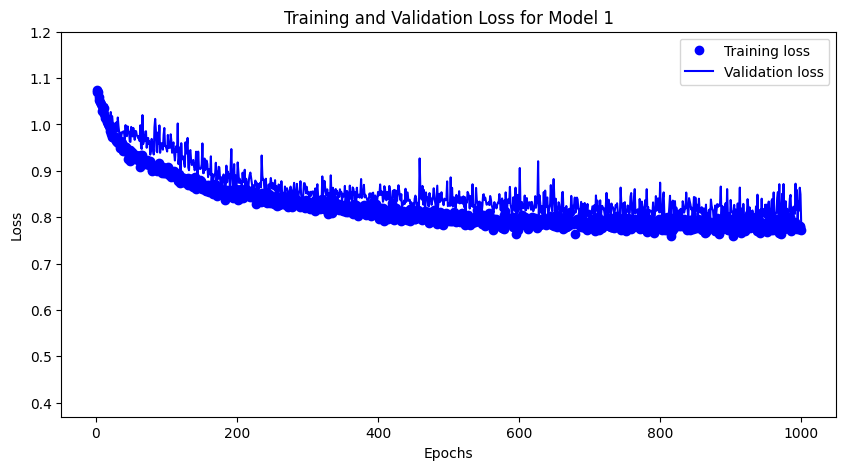

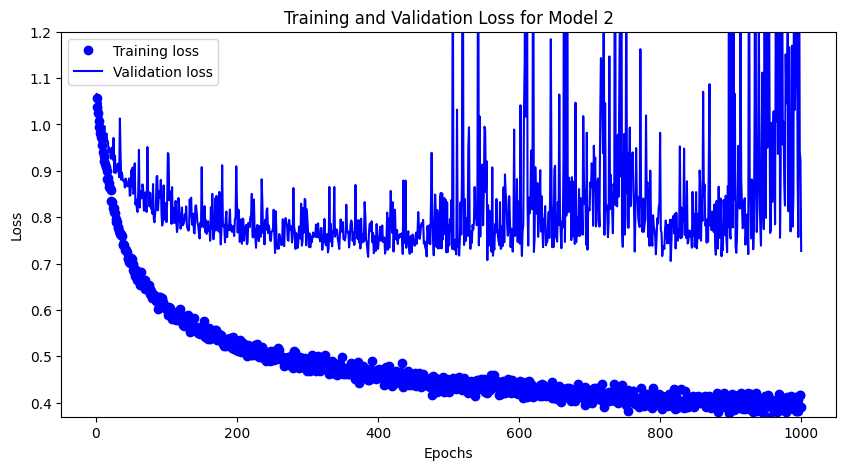

In [16]:
# Get loss and val_loss for the first model
loss1 = fittedModel.history['loss']
val_loss1 = fittedModel.history['val_loss']

# Get loss and val_loss for the second model
loss2 = fittedModel_hp.history['loss']
val_loss2 = fittedModel_hp.history['val_loss']

# Combine all loss values
all_losses = loss1 + val_loss1 + loss2 + val_loss2

# Determine the min and max values
y_min = min(all_losses)
y_max = 1.2

# Plot for the first model
epochs1 = range(1, len(loss1) + 1)
plt.figure(figsize=(10, 5))
plt.plot(epochs1, loss1, 'bo', label='Training loss')
plt.plot(epochs1, val_loss1, 'b', label='Validation loss')
plt.title('Training and Validation Loss for Model 1')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim(y_min, y_max)
plt.legend()
plt.show()

# Plot for the second model
epochs2 = range(1, len(loss2) + 1)
plt.figure(figsize=(10, 5))
plt.plot(epochs2, loss2, 'bo', label='Training loss')
plt.plot(epochs2, val_loss2, 'b', label='Validation loss')
plt.title('Training and Validation Loss for Model 2')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim(y_min, y_max)
plt.legend()
plt.show()


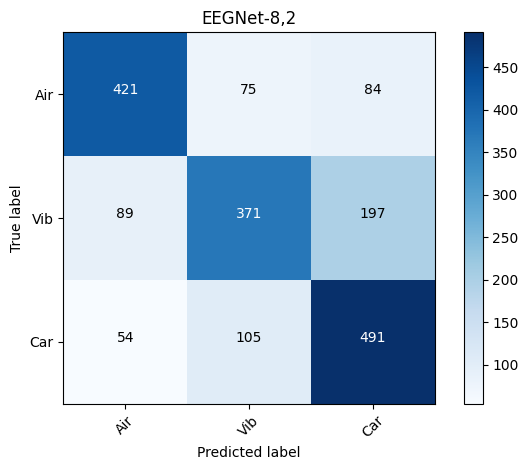

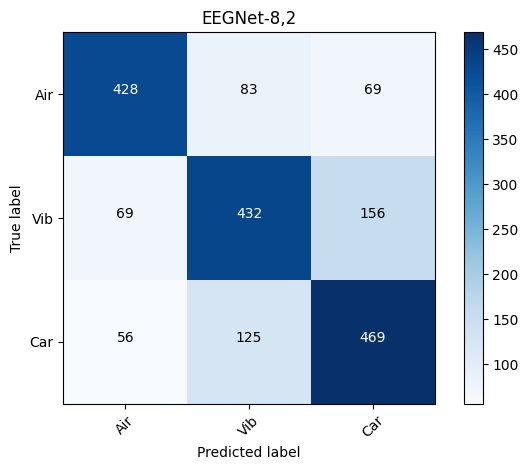

In [70]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns  # For enhanced confusion matrix visualization
import itertools  # Import itertools for product function

def plot_confusion_matrix(cm, classes, title):
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    tick_marks = range(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

# Compute confusion matrices
cm1 = confusion_matrix(y_test.argmax(axis=-1), preds)
names        = ['Air', 'Vib', 'Car']

# Plot the confusion matrices
plt.figure(0)
plot_confusion_matrix(cm1, names, 'EEGNet-8,2')

plt.show()

# Compute confusion matrices
cm1 = confusion_matrix(y_test.argmax(axis=-1), preds_hp)
names        = ['Air', 'Vib', 'Car']

# Plot the confusion matrices
plt.figure(0)
plot_confusion_matrix(cm1, names, 'EEGNet-8,2')

plt.show()

### Saliency map

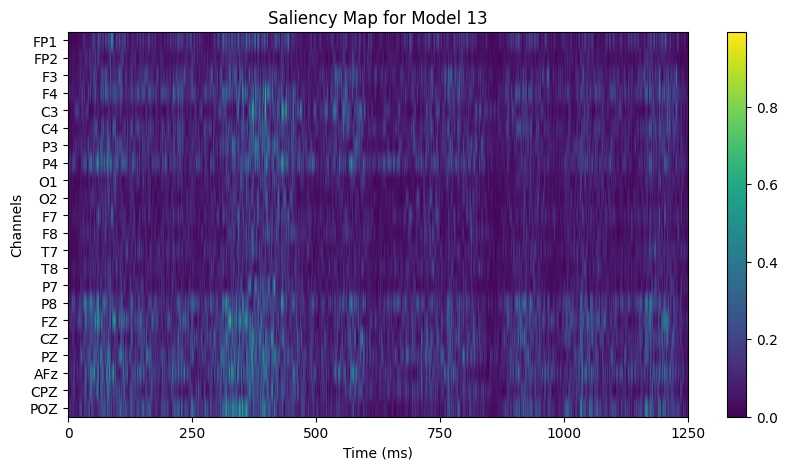

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from tf_keras_vis.saliency import Saliency
from tf_keras_vis.utils.scores import CategoricalScore
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
from tensorflow.keras import backend as K
import pickle

# Replace 'your_file.pkl' with the path to your pickle file
filepath = '/mnt/d/sharegit/MasterThesis_data/' + model_name + '/modelFittedHyperParam.pkl'

with open(filepath, 'rb') as f:
    data = pickle.load(f)

fittedModel_hp = data['fittedModel']
model_hp = data['model']

# load optimal weights
model_hp.load_weights('/mnt/d/sharegit/MasterThesis_data/' + model_name + '/checkpoint_hyperparam.h5')

# Channel mapping
channel_mapping = {
    0: 1,  # 'FP2'
    1: 11,  # 'F8'
    2: 19,  # 'AFz'
    3: 3,  # 'F4'
    4: 10,  # 'F7'
    5: 0,  # 'FP1'
    6: 16,  # 'FZ'
    7: 12,  # 'T7'
    8: 2,  # 'F3'
    9: 4,  # 'C3'
    10: 6,  # 'P3'
    11: 17,  # 'CZ'
    12: 14,  # 'P7'
    13: 8,  # 'O1'
    14: 20,  # 'CPZ'
    15: 18,  # 'PZ'
    16: 5,  # 'C4'
    17: 21,  # 'POZ'
    18: 7,  # 'P4'
    19: 13,  # 'T8'
    20: 9,  # 'O2'
    21: 15  # 'P8'
}

# Order channels by the second number
ordered_channels = sorted(channel_mapping.items(), key=lambda item: item[1])
channel_labels = ['FP2', 'F8', 'AFz', 'F4', 'F7', 'FP1', 'FZ', 'T7', 'F3', 'C3', 'P3', 'CZ', 'P7', 'O1', 'CPZ', 'PZ', 'C4', 'POZ', 'P4', 'T8', 'O2', 'P8']
ordered_channel_labels = [channel_labels[item[0]] for item in ordered_channels]

# Define the score function to maximize the output for the true class
true_classes = np.argmax(y_test)
score = CategoricalScore(true_classes)

# Create a Saliency object with the model and score function
saliency = Saliency(model_hp, model_modifier=ReplaceToLinear(), clone=False)

# Generate saliency map

saliency_maps = saliency(score, X_test)

# Plot the saliency map for the first sample
plt.figure(figsize=(10, 5))
plt.title(f'Saliency Map for Model {i+1}')
plt.imshow(saliency_maps[2], cmap='viridis', aspect='auto')
plt.colorbar()
plt.xlabel('Time (ms)')
plt.ylabel('Channels')

# Set consistent x-ticks from 0 to 1250 ms
num_ticks = 6
time_ticks = np.linspace(0, 1250, num_ticks)
sample_ticks = np.linspace(0, X_test.shape[2], num_ticks)
plt.xticks(sample_ticks, [f'{int(t)}' for t in time_ticks])

# Set y-ticks based on ordered channels
plt.yticks(np.arange(len(ordered_channels)), ordered_channel_labels)

plt.show()

2024-07-18 00:59:22.631409: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-18 00:59:22.939352: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-18 00:59:22.939410: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-18 00:59:22.942476: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-18 00:59:22.942526: I tensorflow/compile

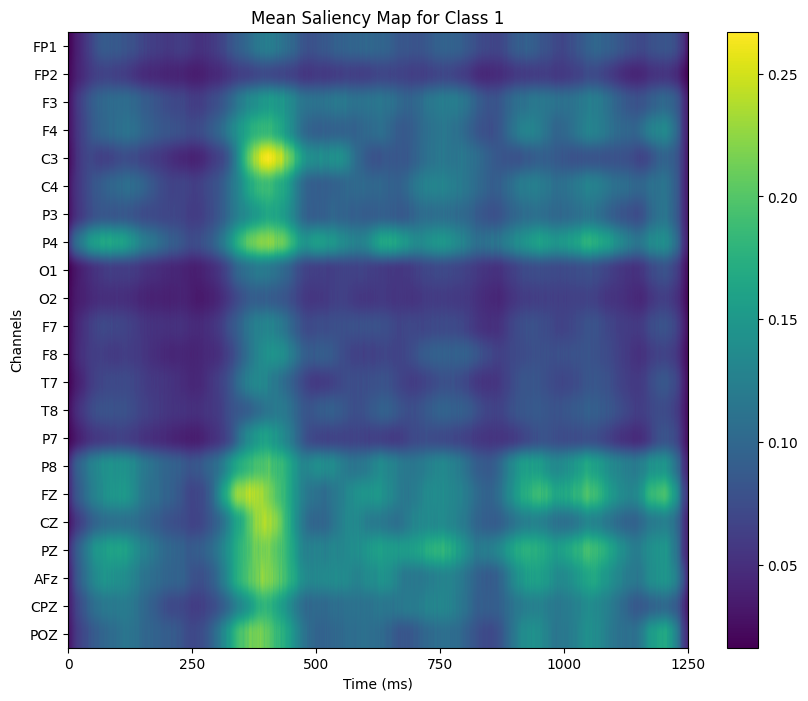

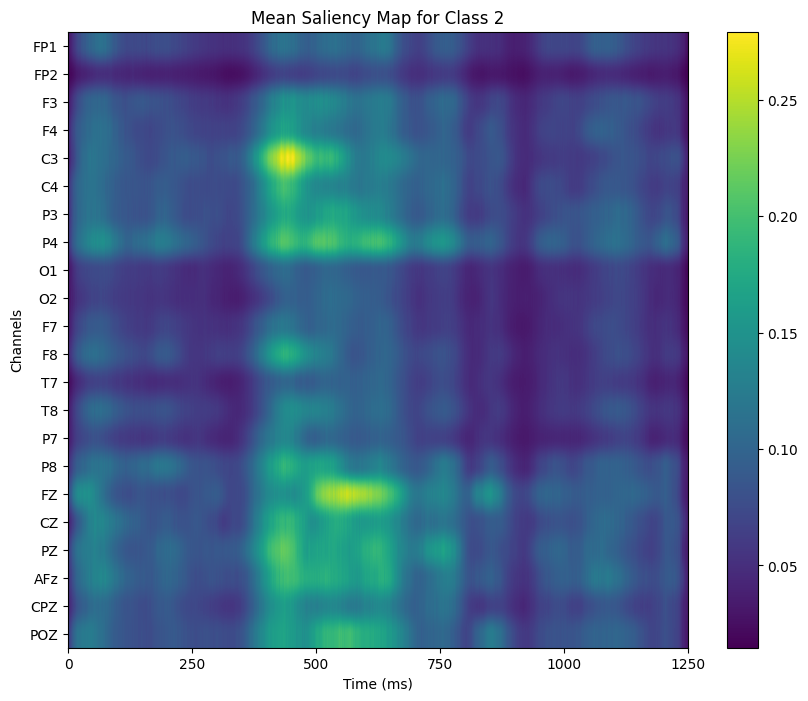

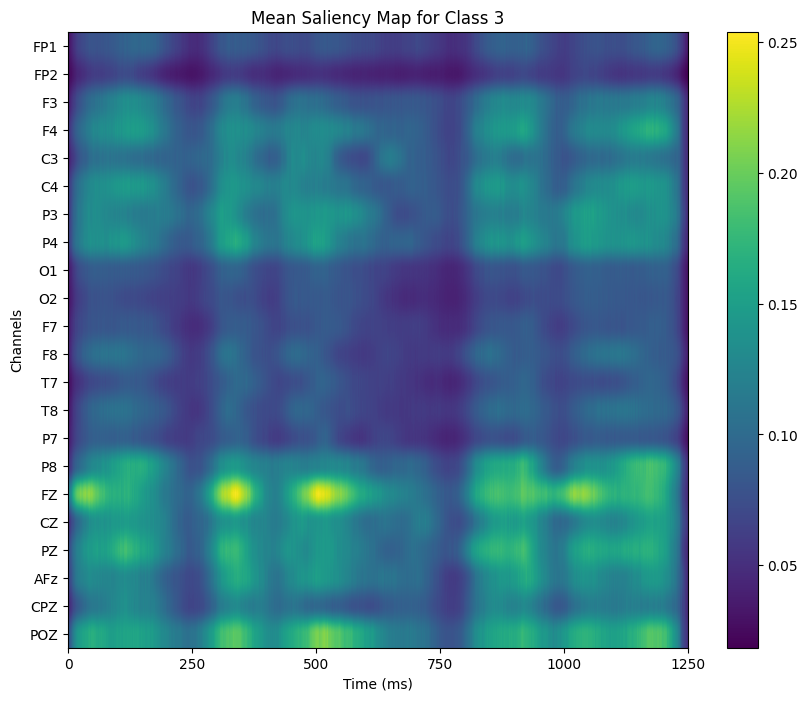

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from tf_keras_vis.saliency import Saliency
from tf_keras_vis.utils.scores import CategoricalScore
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
from tensorflow.keras import backend as K
import pickle

# Replace 'your_file.pkl' with the path to your pickle file
filepath = '/mnt/d/sharegit/MasterThesis_data/' + model_name + '/modelFittedHyperParam.pkl'

with open(filepath, 'rb') as f:
    data = pickle.load(f)

fittedModel_hp = data['fittedModel']
model_hp = data['model']

# load optimal weights
model_hp.load_weights('/mnt/d/sharegit/MasterThesis_data/' + model_name + '/checkpoint_hyperparam.h5')

# Channel mapping
channel_mapping = {
    0: 1,  # 'FP2'
    1: 11,  # 'F8'
    2: 19,  # 'AFz'
    3: 3,  # 'F4'
    4: 10,  # 'F7'
    5: 0,  # 'FP1'
    6: 16,  # 'FZ'
    7: 12,  # 'T7'
    8: 2,  # 'F3'
    9: 4,  # 'C3'
    10: 6,  # 'P3'
    11: 17,  # 'CZ'
    12: 14,  # 'P7'
    13: 8,  # 'O1'
    14: 20,  # 'CPZ'
    15: 18,  # 'PZ'
    16: 5,  # 'C4'
    17: 21,  # 'POZ'
    18: 7,  # 'P4'
    19: 13,  # 'T8'
    20: 9,  # 'O2'
    21: 15  # 'P8'
}

# Order channels by the second number
ordered_channels = sorted(channel_mapping.items(), key=lambda item: item[1])
channel_labels = ['FP2', 'F8', 'AFz', 'F4', 'F7', 'FP1', 'FZ', 'T7', 'F3', 'C3', 'P3', 'CZ', 'P7', 'O1', 'CPZ', 'PZ', 'C4', 'POZ', 'P4', 'T8', 'O2', 'P8']
ordered_channel_labels = [channel_labels[item[0]] for item in ordered_channels]

# Define the score function to maximize the output for each class
saliency = Saliency(model_hp, model_modifier=ReplaceToLinear(), clone=False)

# Generate and plot saliency maps for each class
for class_idx in range(3):
    score = CategoricalScore(class_idx)
    saliency_maps = saliency(score, X_test)
    
    # Compute the mean saliency map for the class
    mean_saliency_map = np.mean(saliency_maps, axis=0)
    
    # Plot the mean saliency map
    plt.figure(figsize=(10, 8))
    plt.title(f'Mean Saliency Map for Class {class_idx + 1}')
    plt.imshow(mean_saliency_map, cmap='viridis', aspect='auto')
    plt.colorbar()
    plt.xlabel('Time (ms)')
    plt.ylabel('Channels')
    
    # Set consistent x-ticks from 0 to 1250 ms
    num_ticks = 6
    time_ticks = np.linspace(0, 1250, num_ticks)
    sample_ticks = np.linspace(0, X_test.shape[2], num_ticks)
    plt.xticks(sample_ticks, [f'{int(t)}' for t in time_ticks])
    
    # Set y-ticks based on ordered channels
    plt.yticks(np.arange(len(ordered_channels)), ordered_channel_labels)
    
    plt.show()


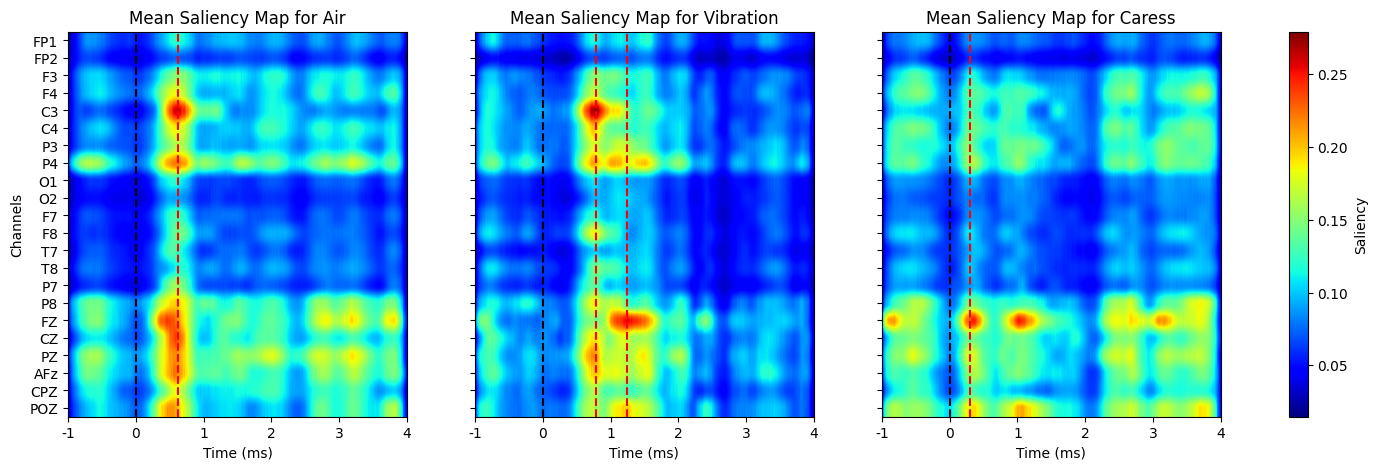

In [88]:
import numpy as np
import matplotlib.pyplot as plt
from tf_keras_vis.saliency import Saliency
from tf_keras_vis.utils.scores import CategoricalScore
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
import pickle

latencies = [620, 790, 300]


# Replace 'your_file.pkl' with the path to your pickle file
filepath = '/mnt/d/sharegit/MasterThesis_data/' + model_name + '/modelFittedHyperParam.pkl'

with open(filepath, 'rb') as f:
    data = pickle.load(f)

fittedModel_hp = data['fittedModel']
model_hp = data['model']

# load optimal weights
model_hp.load_weights('/mnt/d/sharegit/MasterThesis_data/' + model_name + '/checkpoint_hyperparam.h5')

# Channel mapping
channel_mapping = {
    0: 1,  # 'FP2'
    1: 11,  # 'F8'
    2: 19,  # 'AFz'
    3: 3,  # 'F4'
    4: 10,  # 'F7'
    5: 0,  # 'FP1'
    6: 16,  # 'FZ'
    7: 12,  # 'T7'
    8: 2,  # 'F3'
    9: 4,  # 'C3'
    10: 6,  # 'P3'
    11: 17,  # 'CZ'
    12: 14,  # 'P7'
    13: 8,  # 'O1'
    14: 20,  # 'CPZ'
    15: 18,  # 'PZ'
    16: 5,  # 'C4'
    17: 21,  # 'POZ'
    18: 7,  # 'P4'
    19: 13,  # 'T8'
    20: 9,  # 'O2'
    21: 15  # 'P8'
}

# Order channels by the second number
ordered_channels = sorted(channel_mapping.items(), key=lambda item: item[1])
channel_labels = ['FP2', 'F8', 'AFz', 'F4', 'F7', 'FP1', 'FZ', 'T7', 'F3', 'C3', 'P3', 'CZ', 'P7', 'O1', 'CPZ', 'PZ', 'C4', 'POZ', 'P4', 'T8', 'O2', 'P8']
ordered_channel_labels = [channel_labels[item[0]] for item in ordered_channels]

# Create a Saliency object
saliency = Saliency(model_hp, model_modifier=ReplaceToLinear(), clone=False)

# Generate and plot saliency maps for each class
saliency_maps = []
for class_idx in range(3):
    score = CategoricalScore(class_idx)
    saliency_map = saliency(score, X_test)
    saliency_maps.append(np.mean(saliency_map, axis=0))

# Determine common color limits
vmin = min(np.min(map) for map in saliency_maps)
vmax = max(np.max(map) for map in saliency_maps)

Mod = ['Air','Vibration','Caress']
# Plot the saliency maps
fig, axes = plt.subplots(1, 3, figsize=(17.5, 5), sharey=True)

for i, (saliency_map, ax) in enumerate(zip(saliency_maps, axes)):
    im = ax.imshow(saliency_map, cmap='jet', aspect='auto', vmin=vmin, vmax=vmax)
    ax.set_title(f'Mean Saliency Map for {Mod[i]}')
    ax.set_xlabel('Time (ms)')
    ax.set_xlim(0, 1250)
    ax.axvline(x=250, color='black', linestyle='--')
    ax.axvline(x=latencies[i]/4+250  , color='red', linestyle='--')
    if i == 1:
        ax.axvline(x=1250/4+250  , color='red', linestyle='--')

# Set y-ticks based on ordered channels
axes[0].set_yticks(np.arange(len(ordered_channels)))
axes[0].set_yticklabels(ordered_channel_labels)
axes[0].set_ylabel('Channels')

# Add a common color bar
cbar = fig.colorbar(im, ax=axes, orientation='vertical', fraction=.1)
cbar.set_label('Saliency')

# Set consistent x-ticks from -1 to 4 ms
num_ticks = 6
time_ticks = np.linspace(-1, 4, num_ticks)
sample_ticks = np.linspace(0, X_test.shape[2], num_ticks)
for ax in axes:
    ax.set_xticks(sample_ticks)
    ax.set_xticklabels([f'{int(t)}' for t in time_ticks])

plt.savefig(fname = '/mnt/d/sharegit/MasterThesis_data/' + model_name+ '/MeanSaliencyMaps.png')
#plt.tight_layout()
plt.show()



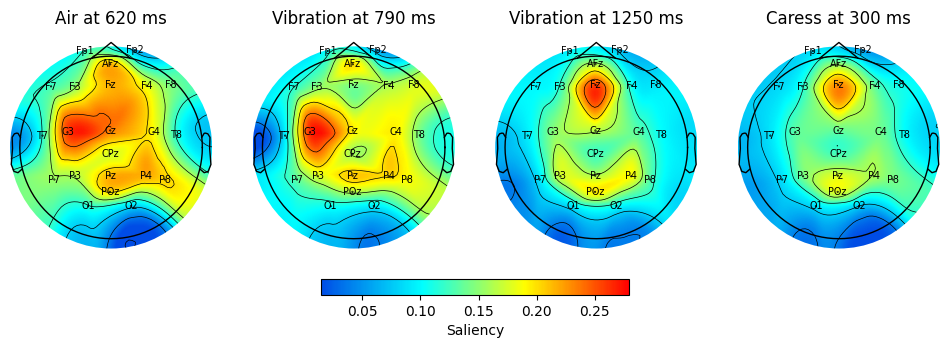

In [92]:
## from mne import create_info
from mne.channels import make_standard_montage
from mne.viz import plot_topomap

# Define tu función personalizada para topoplots
def plot_topoplot(data, times, info, custom_cmap,  labels, save=False, model_name='', fig_name=''):
   
    vmin, vmax = np.min(data), np.max(data)  # Define los límites del color
    fig, axes = plt.subplots(1, len(times), figsize=(3*len(times), 10))
    time_points = np.arange(-1000,4000,1000/250)
    for i, (time, label) in enumerate(zip(times, labels)):
        if label == 'Air':
            mod = 0 
        elif label == 'Vibration':
            mod = 1
        else:
            mod = 2 
        idx = np.argmin(np.abs(np.array(time_points) - time))  # Encuentra el índice más cercano al tiempo especificado
        im, _ = plot_topomap(data[mod,:,idx], info, axes=axes[i], show=False, cmap=custom_cmap, names=channels, vlim=(vmin, vmax))
        axes[i].set_title(f'{label} at {time} ms')
    
    cbar = fig.colorbar(im, ax=axes.ravel().tolist(), orientation='horizontal', fraction=0.02, pad=0.04)
    cbar.set_label('Saliency')
    
    if save:
        save_path = f'/mnt/d/sharegit/MasterThesis_data/{model_name}'
        if not os.path.exists(save_path):
            os.makedirs(save_path)
        plt.savefig(os.path.join(save_path, f'{fig_name}.png'))
    
    plt.show()  # Show the plot after saving

# Define the custom colormap
cdict = {
    'red':   [(0.0, 0.0, 0.0),
              (0.33, 0.0, 0.0),
              (0.66, 1.0, 1.0),
              (1.0, 1.0, 1.0)],
    'green': [(0.0, 0.3, 0.3),  
              (0.33, 1.0, 1.0),
              (0.66, 1.0, 1.0),
              (1.0, 0.0, 0.0)],
    'blue':  [(0.0, 0.9, 0.9),  
              (0.33, 1.0, 1.0),
              (0.66, 0.0, 0.0),
              (1.0, 0.0, 0.0)]
}

custom_cmap = LinearSegmentedColormap('CustomJet', segmentdata=cdict, N=256)

# Configurar información del canal y montaje
channels = ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'AFz', 'CPz', 'POz']
info = create_info(channels, sfreq=250, ch_types='eeg')
info.set_montage(make_standard_montage('standard_1020'))

# Latencias y etiquetas para los momentos específicos
latencies = [620, 790, 1250, 300]  
labels = ['Air', 'Vibration', 'Vibration','Caress']

plot_topoplot(np.array(saliency_maps), latencies, info, custom_cmap, labels, save=False, model_name=model_name, fig_name=f'topoplot_{labels[i]}')

/tmp/ipykernel_81553/26665212.py:113: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


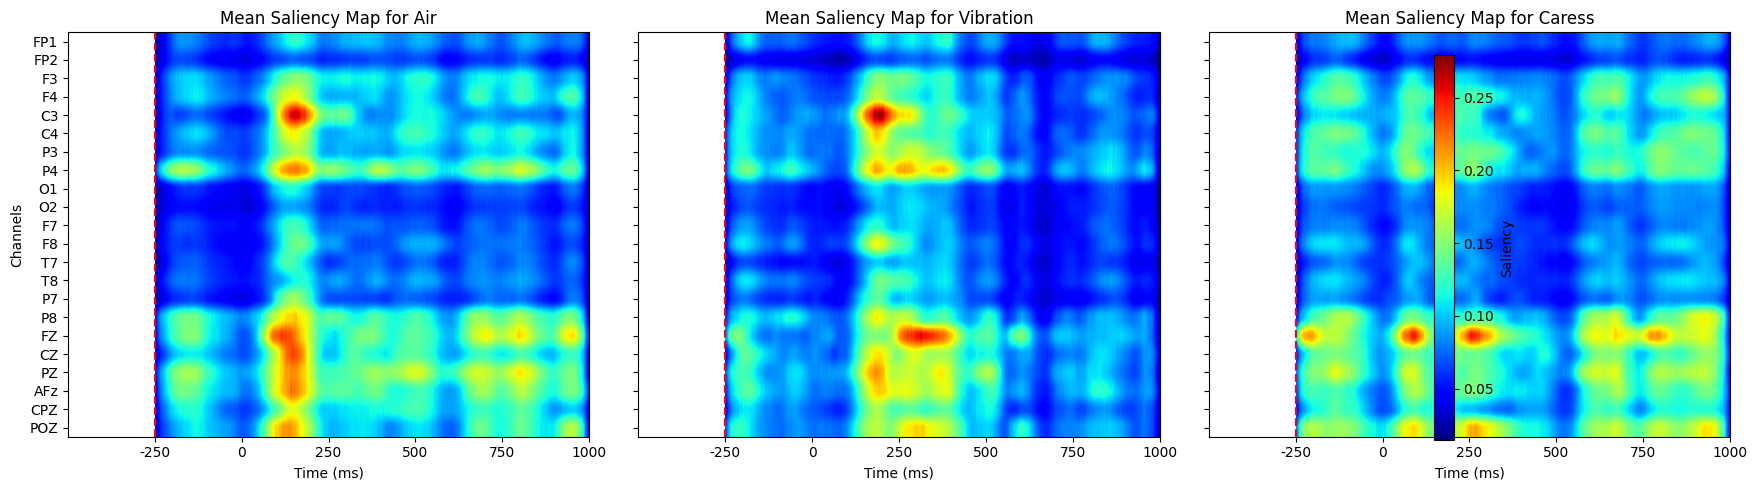

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from tf_keras_vis.saliency import Saliency
from tf_keras_vis.utils.scores import CategoricalScore
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
import pickle

# Define the custom colormap
cdict = {
    'red':   [(0.0, 0.0, 0.0),
              (0.33, 0.0, 0.0),
              (0.66, 1.0, 1.0),
              (1.0, 1.0, 1.0)],
    'green': [(0.0, 0.3, 0.3),  
              (0.33, 1.0, 1.0),
              (0.66, 1.0, 1.0),
              (1.0, 0.0, 0.0)],
    'blue':  [(0.0, 0.9, 0.9),  
              (0.33, 1.0, 1.0),
              (0.66, 0.0, 0.0),
              (1.0, 0.0, 0.0)]
}

custom_cmap = LinearSegmentedColormap('CustomJet', segmentdata=cdict, N=256)

# Replace 'your_file.pkl' with the path to your pickle file
filepath = '/mnt/d/sharegit/MasterThesis_data/' + model_name + '/modelFittedHyperParam.pkl'

with open(filepath, 'rb') as f:
    data = pickle.load(f)

fittedModel_hp = data['fittedModel']
model_hp = data['model']

# load optimal weights
model_hp.load_weights('/mnt/d/sharegit/MasterThesis_data/' + model_name + '/checkpoint_hyperparam.h5')

# Channel mapping
channel_mapping = {
    0: 1,  # 'FP2'
    1: 11,  # 'F8'
    2: 19,  # 'AFz'
    3: 3,  # 'F4'
    4: 10,  # 'F7'
    5: 0,  # 'FP1'
    6: 16,  # 'FZ'
    7: 12,  # 'T7'
    8: 2,  # 'F3'
    9: 4,  # 'C3'
    10: 6,  # 'P3'
    11: 17,  # 'CZ'
    12: 14,  # 'P7'
    13: 8,  # 'O1'
    14: 20,  # 'CPZ'
    15: 18,  # 'PZ'
    16: 5,  # 'C4'
    17: 21,  # 'POZ'
    18: 7,  # 'P4'
    19: 13,  # 'T8'
    20: 9,  # 'O2'
    21: 15  # 'P8'
}

# Order channels by the second number
ordered_channels = sorted(channel_mapping.items(), key=lambda item: item[1])
channel_labels = ['FP2', 'F8', 'AFz', 'F4', 'F7', 'FP1', 'FZ', 'T7', 'F3', 'C3', 'P3', 'CZ', 'P7', 'O1', 'CPZ', 'PZ', 'C4', 'POZ', 'P4', 'T8', 'O2', 'P8']
ordered_channel_labels = [channel_labels[item[0]] for item in ordered_channels]

# Create a Saliency object
saliency = Saliency(model_hp, model_modifier=ReplaceToLinear(), clone=False)

# Generate and plot saliency maps for each class
saliency_maps = []
for class_idx in range(3):
    score = CategoricalScore(class_idx)
    saliency_map = saliency(score, X_test)
    saliency_maps.append(np.mean(saliency_map, axis=0))

# Determine common color limits
vmin = min(np.min(map) for map in saliency_maps)
vmax = max(np.max(map) for map in saliency_maps)

Mod = ['Air', 'Vibration', 'Caress']
# Plot the saliency maps
fig, axes = plt.subplots(1, 3, figsize=(17.5, 5), sharey=True)

for i, (saliency_map, ax) in enumerate(zip(saliency_maps, axes)):
    im = ax.imshow(saliency_map, cmap='jet', aspect='auto', vmin=vmin, vmax=vmax)
    ax.set_title(f'Mean Saliency Map for {Mod[i]}')
    ax.set_xlabel('Time (ms)')
    ax.set_xlim(-250, 1000)
    ax.axvline(x=0, color='red', linestyle='--')

# Set y-ticks based on ordered channels
axes[0].set_yticks(np.arange(len(ordered_channels)))
axes[0].set_yticklabels(ordered_channel_labels)
axes[0].set_ylabel('Channels')

# Add a common color bar
cbar = fig.colorbar(im, ax=axes, orientation='vertical', fraction=.1)
cbar.set_label('Saliency')

# Set consistent x-ticks from -250 to 1000 ms
num_ticks = 6
time_ticks = np.linspace(-250, 1000, num_ticks)
sample_ticks = np.linspace(0, X_test.shape[2], num_ticks)
for ax in axes:
    ax.set_xticks(sample_ticks)
    ax.set_xticklabels([f'{int(t)}' for t in time_ticks])

plt.savefig(fname='/mnt/d/sharegit/MasterThesis_data/' + model_name + '/MeanSaliencyMaps.png')
plt.tight_layout()
plt.show()
